# Predicting Stock Prices

This project is taken up to demonstrate Machine Learning's ability to predict one of the most challenging problems in financial world - "to predict the unpredictable" - predict the stock price.

In this project, I have used only those techniques which we have studied in Topic 9 of the course with regards to Time Series analysis.

For a use case to show the predictive power of very simple algorithms such as Lasso AND Ridge regressions, I have downloaded the data for a very famous stock in India - **"TATA MOTORS"**.

The link to this data is mentioned here -

https://in.finance.yahoo.com/quote/TATAMOTORS.NS/history?period1=662754600&period2=1544985000&interval=1d&filter=history&frequency=1d

There are few important characteristics which I would like to outline here:

1. We have around 17 years of information (from 02 Jan 1991 till 14 Dec 2018)


2. There are two types of prices given in the data:

    a. Closing Prices which do not take into account of any corporate actions in the prices such as declaration of dividends or split of shares effect.
    
    b. Adjusted Closing Prices which do take care of effect of Dividend payments and stock split. [**This will be our target variable**]

    
3. There are other information available as well in the data which may not be useful for our analysis point of view.

So, let's dive in.

First we will download all basic libraries into Pythnon

## Loading Libraries and Data

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading basic ML algoriths
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# few powerful algorithms as well which we will see later dont perform well compared to basic algorithms
import xgboost
import lightgbm

In [3]:
# load the downloaded data
import os
os.chdir('C:\\Users\\Abhik\\mlcourse.ai\\mlcourse.ai-master\\data')

In [4]:
# load the data into pandas dataframe
df = pd.read_csv('TATAMOTORS.NS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-01-02,20.9596,21.857901,20.9596,21.857901,4.031160,0.0
1,1991-01-03,20.9596,21.857901,20.9596,21.857901,4.031160,0.0
2,1991-01-04,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-01-07,20.3608,21.259001,20.0613,21.109301,3.893099,0.0
4,1991-01-08,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# since there are few NaN values, we should remove these first
df.dropna(axis=0, inplace=True)

In [6]:
# Lets check the data once again
df.head(6)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-01-02,20.959600,21.857901,20.9596,21.857901,4.031160,0.0
1,1991-01-03,20.959600,21.857901,20.9596,21.857901,4.031160,0.0
3,1991-01-07,20.360800,21.259001,20.0613,21.109301,3.893099,0.0
5,1991-01-09,21.259001,21.259001,20.0613,20.510500,3.782665,0.0
7,1991-01-11,20.360800,20.959600,20.0613,20.959600,3.865490,0.0
8,1991-01-14,20.660200,20.660200,20.0613,20.360800,3.755056,0.0


In [7]:
# We now need to convert the Dates into Pandas Date format
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

In [8]:
# Better to check the data once again
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1991-01-02,1991-01-02,20.959600,21.857901,20.9596,21.857901,4.031160,0.0
1991-01-03,1991-01-03,20.959600,21.857901,20.9596,21.857901,4.031160,0.0
1991-01-07,1991-01-07,20.360800,21.259001,20.0613,21.109301,3.893099,0.0
1991-01-09,1991-01-09,21.259001,21.259001,20.0613,20.510500,3.782665,0.0
1991-01-11,1991-01-11,20.360800,20.959600,20.0613,20.959600,3.865490,0.0


## EDA and Feature Engineering

In [9]:
# Plot the Graph for Adjusted Closing Price

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [10]:
trace1 = go.Scatter(
    x=df.Date,
    y=df['Adj Close'],
    name='Closing Price'
)
data = [trace1]
layout = {'title': 'Adjusted Closing Price'}
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [11]:
# Shape of the Data
df.shape

(6734, 7)

In [12]:
# Lets create a new dataset in which we will only store the required inputs.

#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Adj Close'][i]
    

In [13]:
# Lets check the Data once again
new_data.head()

,Date,Close
0,1991-01-02 00:00:00,4.03116
1,1991-01-03 00:00:00,4.03116
2,1991-01-07 00:00:00,3.8931
3,1991-01-09 00:00:00,3.78267
4,1991-01-11 00:00:00,3.86549


In [14]:
# We will create a number of features on the Dates

new_data['year'] = new_data['Date'].map(lambda x : x.year)
new_data['month'] = new_data['Date'].map(lambda x : x.month)
new_data['day_week'] = new_data['Date'].map(lambda x : x.dayofweek)
new_data['quarter'] = new_data['Date'].map(lambda x : x.quarter)
new_data['week'] = new_data['Date'].map(lambda x : x.week)
new_data['quarter_start'] = new_data['Date'].map(lambda x : x.is_quarter_start)
new_data['quarter_end'] = new_data['Date'].map(lambda x : x.is_quarter_end)
new_data['month_start'] = new_data['Date'].map(lambda x : x.is_month_start)
new_data['month_end'] = new_data['Date'].map(lambda x : x.is_month_end)
new_data['year_start'] = new_data['Date'].map(lambda x : x.is_year_start)
new_data['year_end'] = new_data['Date'].map(lambda x : x.is_year_end)
new_data['week_year'] = new_data['Date'].map(lambda x : x.weekofyear)
new_data['quarter_start'] = new_data['quarter_start'].map(lambda x: 0 if x is False else 1)
new_data['quarter_end'] = new_data['quarter_end'].map(lambda x: 0 if x is False else 1)
new_data['month_start'] = new_data['month_start'].map(lambda x: 0 if x is False else 1)
new_data['month_end'] = new_data['month_end'].map(lambda x: 0 if x is False else 1)
new_data['year_start'] = new_data['year_start'].map(lambda x: 0 if x is False else 1)
new_data['year_end'] = new_data['year_end'].map(lambda x: 0 if x is False else 1)
new_data['day_month'] = new_data['Date'].map(lambda x: x.daysinmonth)

# Create a feature which could be important - Markets are only open between Monday and Friday.
mon_fri_list = [0,4]
new_data['mon_fri'] = new_data['day_week'].map(lambda x: 1 if x in mon_fri_list  else 0)

In [15]:
# Re-indexing the data
new_data.index = new_data['Date']
new_data.drop('Date', inplace=True, axis=1)
new_data.head(2)

,Close,year,month,day_week,quarter,week,quarter_start,quarter_end,month_start,month_end,year_start,year_end,week_year,day_month,mon_fri
Date,,,,,,,,,,,,,,,
1991-01-02,4.03116,1991,1,2,1,1,0,0,0,0,0,0,1,31,0
1991-01-03,4.03116,1991,1,3,1,1,0,0,0,0,0,0,1,31,0


Lags are very important features which need to be created for any time-series prediction as it will define the auto-correlation effect between past observations.

Here we have taken the lag period of 1 to 22 days (since the market opens for around 22 days in a month)

In [16]:
for i in range(1, 22):
        new_data["lag_{}".format(i)] = new_data.Close.shift(i)

In [17]:
new_data.head(3)

,Close,year,month,day_week,quarter,week,quarter_start,quarter_end,month_start,month_end,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
Date,,,,,,,,,,,,,,,,,,,,,
1991-01-02,4.03116,1991,1,2,1,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-03,4.03116,1991,1,3,1,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-07,3.8931,1991,1,0,1,2,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Lets create dummies for categorical features

cols = ['year', 'month', 'day_week', 'quarter', 'week', 
        'quarter_start', 'quarter_end', 'week_year', 'mon_fri', 'year_start', 'year_end',
       'month_start', 'month_end', 'day_month']

for i in cols:
    new_data = pd.concat([new_data.drop([i], axis=1), 
        pd.get_dummies(new_data[i], prefix=i)
    ], axis=1)

In [19]:
# Droping NAs if any and re-indexing again

new_data = new_data.dropna()
new_data = new_data.reset_index(drop=True)

In [20]:
new_data.head()

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,year_end_0,year_end_1,month_start_0,month_start_1,month_end_0,month_end_1,day_month_28,day_month_29,day_month_30,day_month_31
0,3.67221,3.75506,3.25807,3.23044,3.17522,3.3685,3.47893,3.58939,3.69982,3.69982,...,1,0,1,0,1,0,1,0,0,0
1,3.6446,3.67221,3.75506,3.25807,3.23044,3.17522,3.3685,3.47893,3.58939,3.69982,...,1,0,1,0,1,0,1,0,0,0
2,3.81027,3.6446,3.67221,3.75506,3.25807,3.23044,3.17522,3.3685,3.47893,3.58939,...,1,0,1,0,1,0,1,0,0,0
3,4.11399,3.81027,3.6446,3.67221,3.75506,3.25807,3.23044,3.17522,3.3685,3.47893,...,1,0,1,0,1,0,1,0,0,0
4,4.25205,4.11399,3.81027,3.6446,3.67221,3.75506,3.25807,3.23044,3.17522,3.3685,...,1,0,1,0,1,0,1,0,0,0


In [21]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6713 entries, 0 to 6712
Columns: 195 entries, Close to day_month_31
dtypes: object(22), uint8(173)
memory usage: 2.2+ MB


In [22]:
# Target Variable
y = new_data.Close.values
y

array([3.6722120000000005, 3.644603, 3.8102730000000005, ..., 164.100006,
       166.850006, 166.949997], dtype=object)

## Splitting the Data into Train-Test

In [23]:
# Creating splitting index

test_index = int(len(new_data) * (1 - 0.30))
test_index

4699

Since we dont want to look into immediate future, we are creating a window of 2 days. This means, training data will stop at day x-1 and test data will start at x+1.

In [24]:
# splitting whole dataset on train and test

X_train = new_data.loc[:test_index-1].drop(['Close'], axis=1)
y_train = new_data.loc[:test_index-1]["Close"]
X_test = new_data.loc[test_index+1:].drop(["Close"], axis=1)
y_test = new_data.loc[test_index+1:]["Close"]  

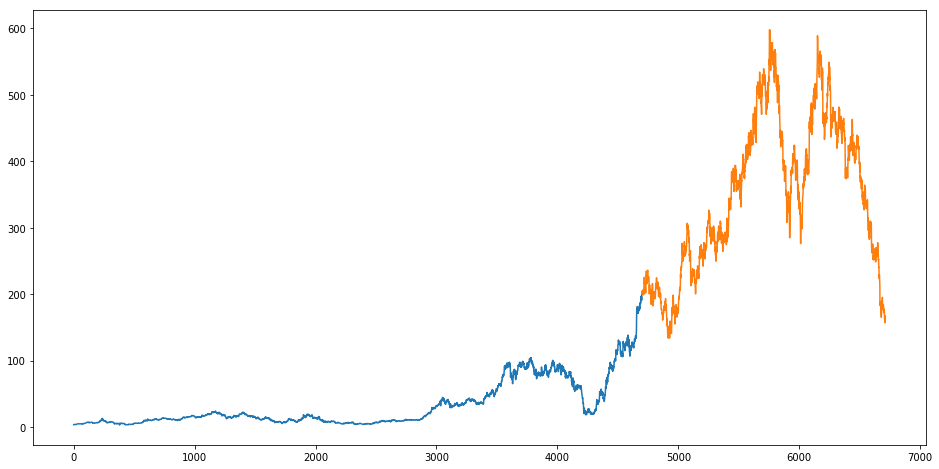

In [25]:
# Lets visualize the train and test data together
plt.figure(figsize=(16,8))
plt.plot(y_train)
plt.plot(y_test)

In [26]:
# Scaling the Data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Machine Learning implementations

In [27]:
# First we will use the simplest of them all - Linear Regression

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

For Cross Validation (CV) on Time Series data, we will use **TimeSeries Split** for CV.

Let's see Mean Absolute Error for our simplest model

In [28]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(lr, X_train_scaled, y_train, scoring = 'neg_mean_absolute_error', cv=tscv)
mae = cv.mean()*(-1)
mae

6573780029897.434

Oh Gosh!! Linear Regression failed miserably to predict the pattern. Lets try regularized linear models.

But before that, we will use the plotting module written in Topic 9 of the course to plot some nice graphs

In [29]:
def plotModelResults(model, df_train, df_test, y_train, y_test, plot_intervals=False, plot_anomalies=False, scale=1.96, cv=tscv):
    """
    Plots modelled vs fact values
    
    model: fitted model 
    
    df_train, df_test: splitted featuresets
    
    y_train, y_test: targets
    
    plot_intervals: bool, if True, plot prediction intervals
    
    scale: float, sets the width of the intervals
    
    cv: cross validation method, needed for intervals
    
    """
    # making predictions for test
    prediction = model.predict(df_test)
    
    plt.figure(figsize=(20, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        # calculate cv scores
        cv = cross_val_score(
            model, 
            df_train, 
            y_train, 
            cv=cv, 
            scoring="neg_mean_squared_error"
        )

        # calculate cv error deviation
        deviation = np.sqrt(cv.std())
        
        # calculate lower and upper intervals
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
        
    # calculate overall quality on test set
    mae  = mean_absolute_error(prediction, y_test)
    mape = mean_absolute_percentage_error(prediction, y_test)
    plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))
    plt.legend(loc="best")
    plt.grid(True);

Another plotting module for Coefficients

In [30]:
def getCoefficients(model):
    """Returns sorted coefficient values of the model"""
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)    
    

def plotCoefficients(model):
    """Plots sorted coefficient values of the model"""
    coefs = getCoefficients(model)
    
    plt.figure(figsize=(20, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.show()

We will define a loss metric - namely - *Mean Absolute Percentage Error* which calculated Mean Absolute Error in percentage

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Let's see the plot for Linear Regression

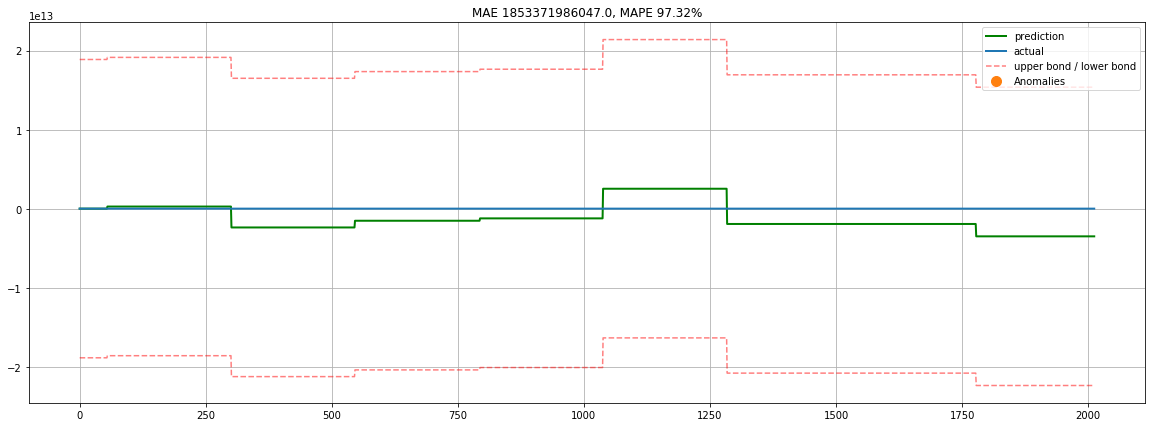

In [32]:
plotModelResults(lr, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)

This plot does not tell us much apart from the fact that our model has faired poorly in predicting the pattern.

Lets see the plot for coefficients

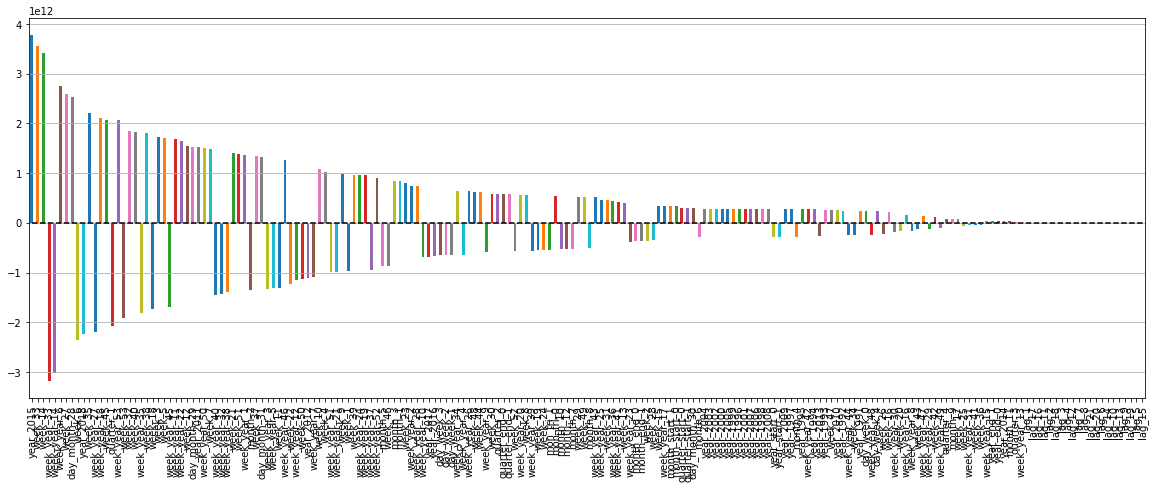

In [33]:
plotCoefficients(lr)

Lets see the correlation matrix and Heat Map for the features

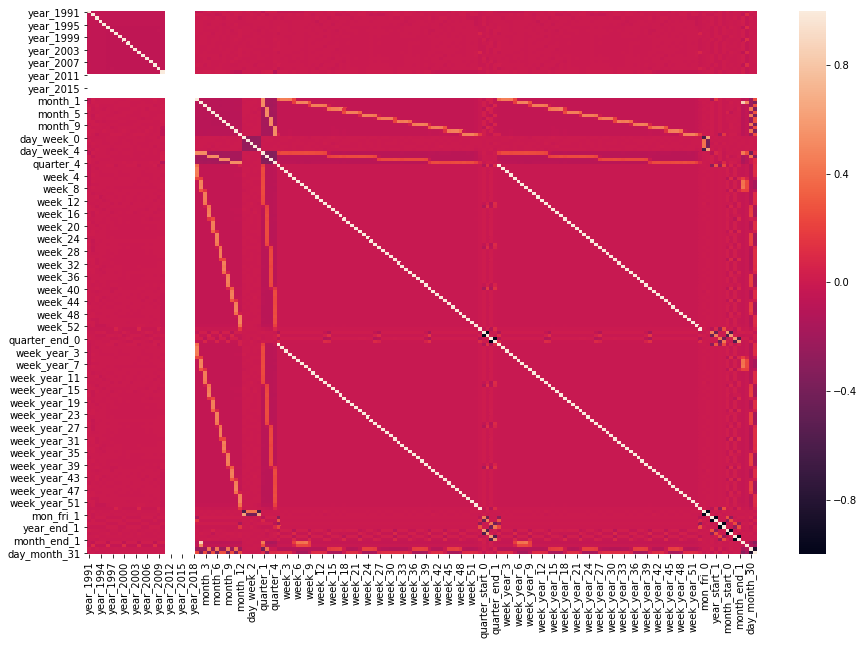

In [34]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(X_train.corr())

Not much information can be derived from this Heat Map - only crucial information is prices in few years are completely uncorrelated.

Lets create our next model - Lasso Regression

In [35]:
lasso = LassoCV(cv =tscv, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True,
    cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
    fit_intercept=True, max_iter=10000, n_alphas=100, n_jobs=None,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

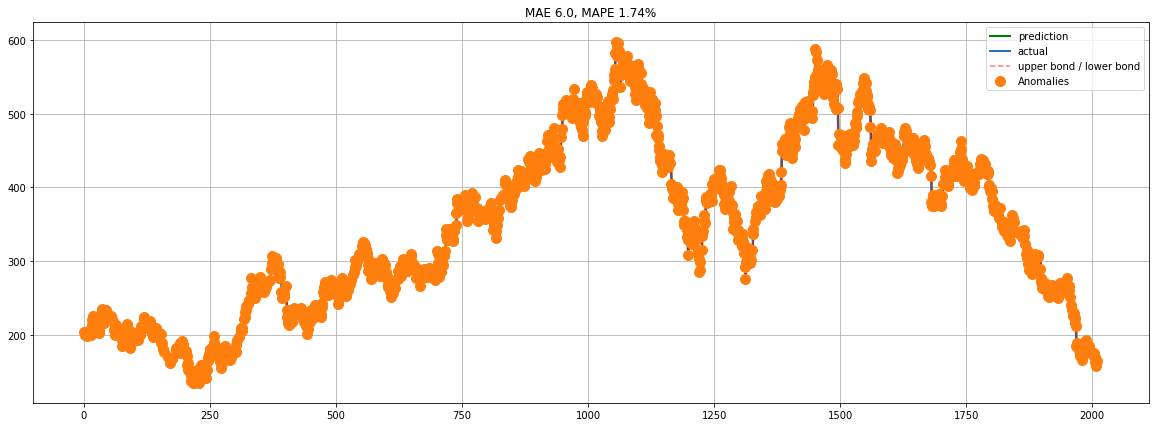

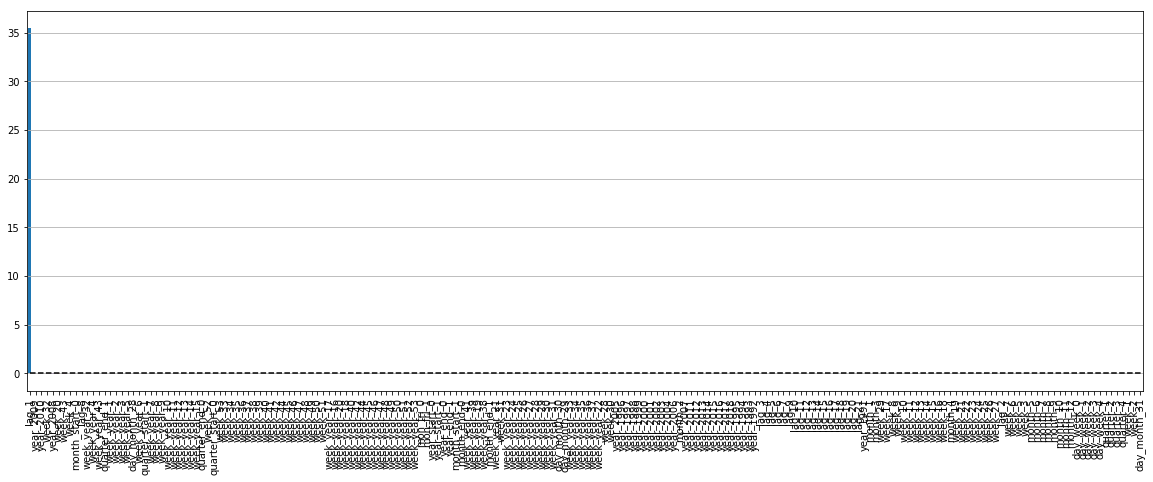

In [36]:
plotModelResults(lasso, 
                 X_train_scaled, 
                 X_test_scaled,
                 y_train, 
                 y_test,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

In [37]:
coef = getCoefficients(lasso)
np.count_nonzero(np.where(coef['coef']==0.000000))

181

Oh wow!

Around 181 features were of no value which are elimiated by the Lasso Regression

Let's see important features (Top10)

In [38]:
coef.sort_values(by='coef', ascending=False).head(10)

,coef
lag_1,3.550651e+01
year_2009,5.308872e-02
year_2010,3.609759e-02
week_32,3.299126e-02
lag_8,2.146558e-03
week_year_32,4.339372e-07
lag_11,0.000000e+00
year_1993,-0.000000e+00
year_1992,-0.000000e+00
lag_3,0.000000e+00


It turns out that **Lag 1** is the most important feature

Lets see how close our predicted values are compared to actual values

In [39]:
from sklearn.linear_model import Lasso
lasso = Lasso(max_iter=10000, random_state=17)

lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

columns = ['Close_actual', 'Close_pred']
df_pred_lasso = pd.DataFrame(columns = columns)

df_pred_lasso.Close_actual = y_test
df_pred_lasso.Close_pred = y_pred

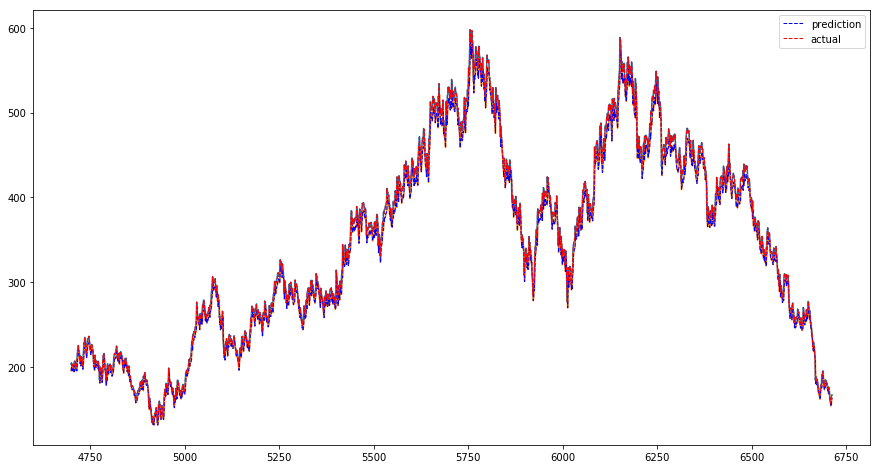

In [40]:
plt.figure(figsize=(15,8))
plt.plot(df_pred_lasso)
plt.plot(df_pred_lasso.Close_pred, "b--", label="prediction", linewidth=1.0)
plt.plot(df_pred_lasso.Close_actual, "r--", label="actual", linewidth=1)
plt.legend(loc="best")

In [41]:
df_pred_lasso['diff'] = df_pred_lasso.Close_actual - df_pred_lasso.Close_pred
df_pred_lasso['perc_diff'] = ((df_pred_lasso['diff']) / (df_pred_lasso['Close_pred']))

df_pred_lasso.head(20)

,Close_actual,Close_pred,diff,perc_diff
4700,203.47,195.652330,7.81726,0.0399548
4701,204.664,198.977729,5.68589,0.0285755
4702,199.958,200.140080,-0.181813,-0.000908429
4703,202.19,195.559567,6.63034,0.0339045
4704,203.089,197.732002,5.35734,0.0270939
4705,200.235,198.607568,1.62781,0.00819613
4706,201.87,195.829330,6.04064,0.0308464
4707,198.714,197.420545,1.293,0.00654948
4708,205.079,194.347871,10.731,0.0552153
4709,206.652,200.544286,6.10794,0.0304568


Amazing!!

Lasso Regression has done a very nice job in predicting the adjusted closing price of this stock

We can also run PCA to eliminate more features and noises from the data

In [42]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

def plotPCA(pca):
    """
    Plots accumulated percentage of explained variance by component
    
    pca: fitted PCA object
    """
    components = range(1, pca.n_components_ + 1)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.figure(figsize=(20, 10))
    plt.bar(components, variance)
    
    # additionally mark the level of 95% of explained variance 
    plt.hlines(y = 95, xmin=0, xmax=len(components), linestyles='dashed', colors='red')
    
    plt.xlabel('PCA components')
    plt.ylabel('variance')
    plt.xticks(components)
    plt.show()

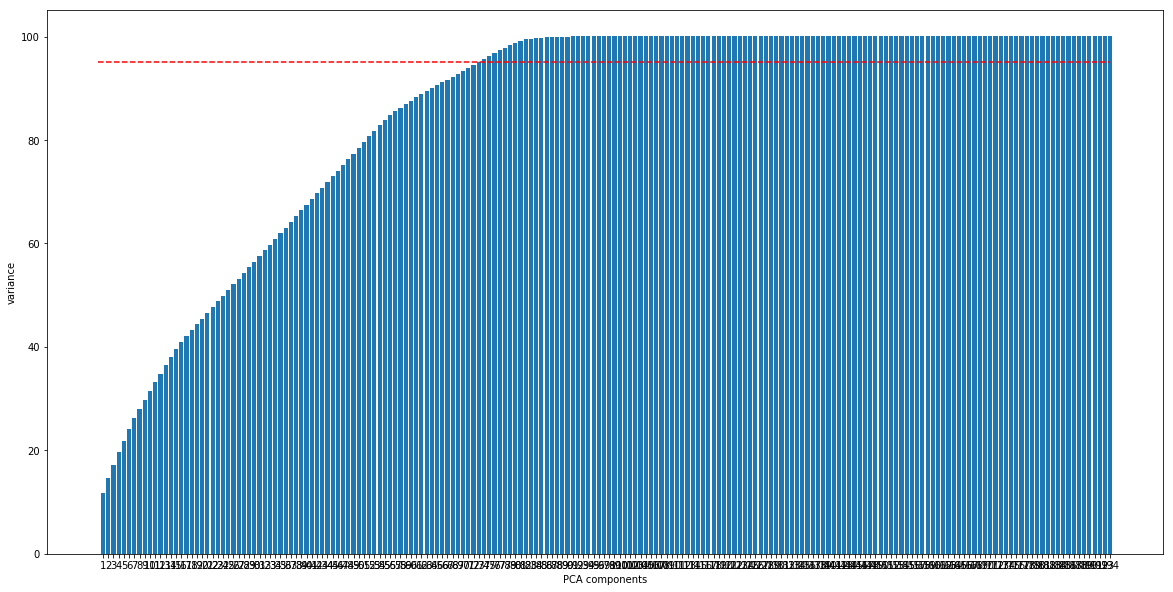

In [43]:
# Create PCA object: pca
pca = PCA()


# Train PCA on scaled data
pca = pca.fit(X_train_scaled)

# plot explained variance
plotPCA(pca)

In [44]:
pca_comp = PCA(0.95).fit(X_train_scaled)
print('We need %d components to explain 95%% of variance' 
      % pca_comp.n_components_)

We need 73 components to explain 95% of variance


PCA needs only 73 components to explain the variance. 

Lets fit and transform train and test data with these components

In [45]:
pca = PCA(n_components=pca_comp.n_components).fit(X_train_scaled)

pca_features_train = pca.transform(X_train_scaled)
pca_features_test = pca.transform(X_test_scaled)

Lets run the Linear Regression model once again to see if there are any improvements since last time

In [46]:
lr.fit(pca_features_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

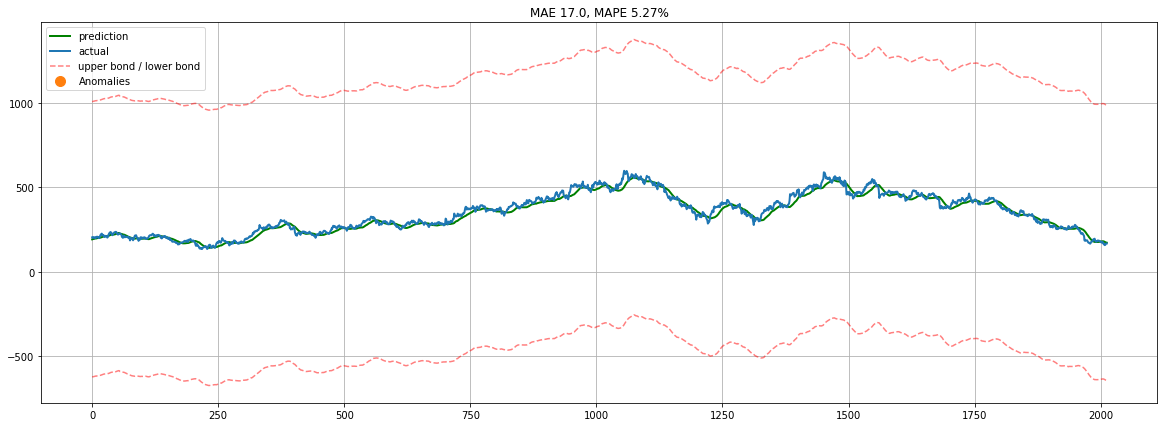

In [47]:
plotModelResults(lr, pca_features_train, pca_features_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)

Super!

PCA has resulted into an improvement in the linear regression model

Lets run another model - Ridge Regression and see how does it fare

In [48]:
from sklearn.linear_model import Ridge
ridge = Ridge(max_iter=10000, random_state=17)

ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)

columns = ['Close_actual', 'Close_pred']
df_pred_ridge = pd.DataFrame(columns = columns)

df_pred_ridge.Close_actual = y_test
df_pred_ridge.Close_pred = y_pred

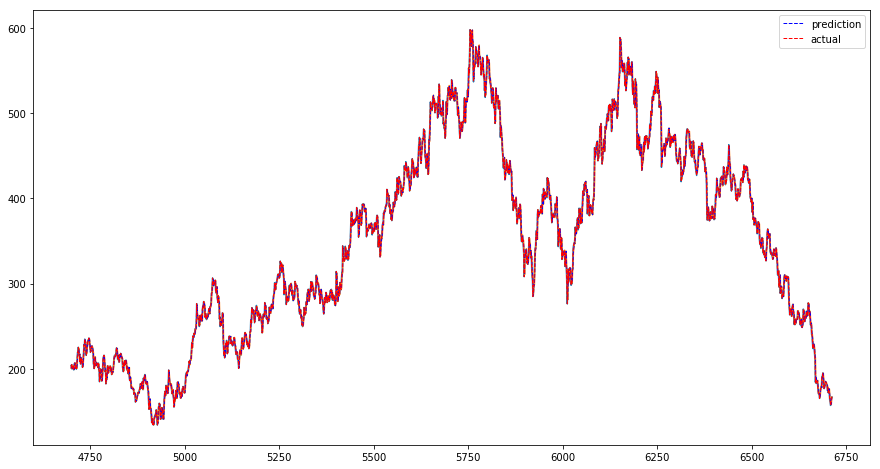

In [49]:
plt.figure(figsize=(15,8))
plt.plot(df_pred_ridge)
plt.plot(df_pred_ridge.Close_pred, "b--", label="prediction", linewidth=1.0)
plt.plot(df_pred_ridge.Close_actual, "r--", label="actual", linewidth=1.0)
plt.legend(loc="best")

In [50]:
df_pred_ridge['diff'] = df_pred_ridge.Close_actual - df_pred_ridge.Close_pred
df_pred_ridge['perc_diff'] = ((df_pred_ridge['diff']) / (df_pred_ridge['Close_pred']))*100
df_pred_ridge.head(20)

,Close_actual,Close_pred,diff,perc_diff
4700,203.47,200.768340,2.70125,1.34546
4701,204.664,203.476201,1.18742,0.583567
4702,199.958,204.929404,-4.97114,-2.42578
4703,202.19,200.250048,1.93986,0.96872
4704,203.089,201.988105,1.10124,0.545198
4705,200.235,203.377847,-3.14247,-1.54514
4706,201.87,200.325602,1.54436,0.770926
4707,198.714,202.340981,-3.62743,-1.79273
4708,205.079,199.281304,5.79754,2.90922
4709,206.652,204.530661,2.12156,1.03728


Not Bad at all!

Lasso and Ridge turned out to quite close and already are superstars

Lets see the plots for Ridge

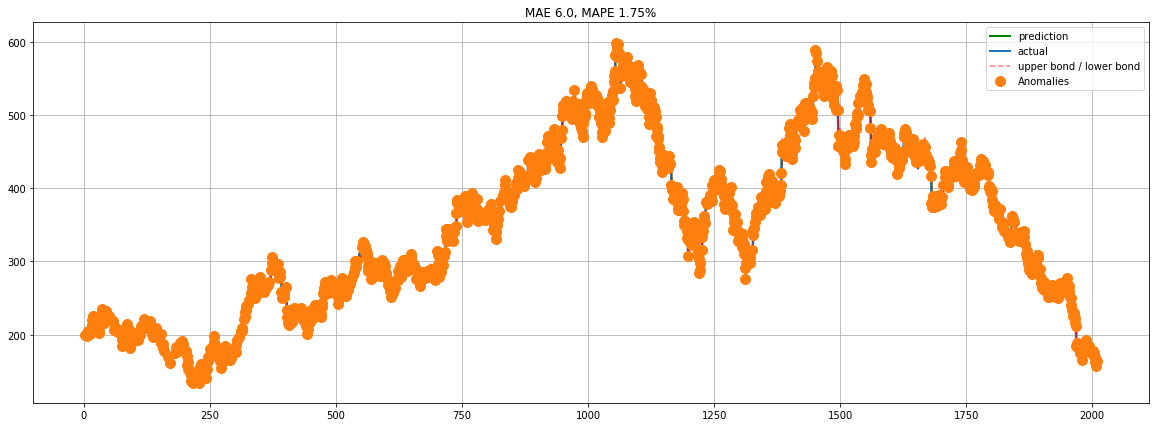

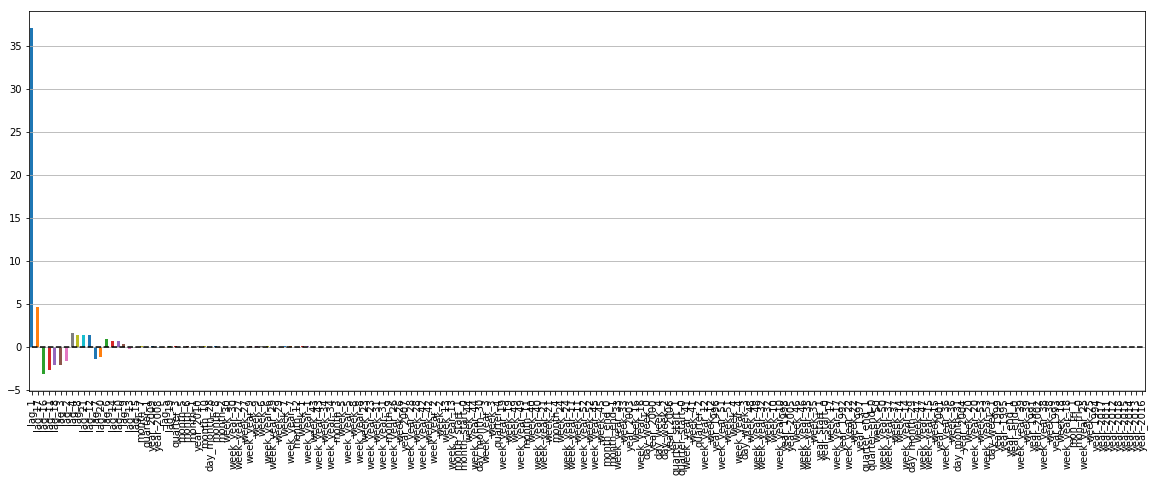

In [51]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

Now Lets see how Lasso and Ridge are performing on PCA transformed data

In [52]:
from sklearn.linear_model import Lasso
Lasso = Lasso(max_iter=10000)
Lasso.fit(pca_features_train, y_train)

from sklearn.linear_model import Ridge
ridge = Ridge(max_iter=10000, random_state=17)
ridge.fit(pca_features_train, y_train)


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, random_state=17, solver='auto', tol=0.001)

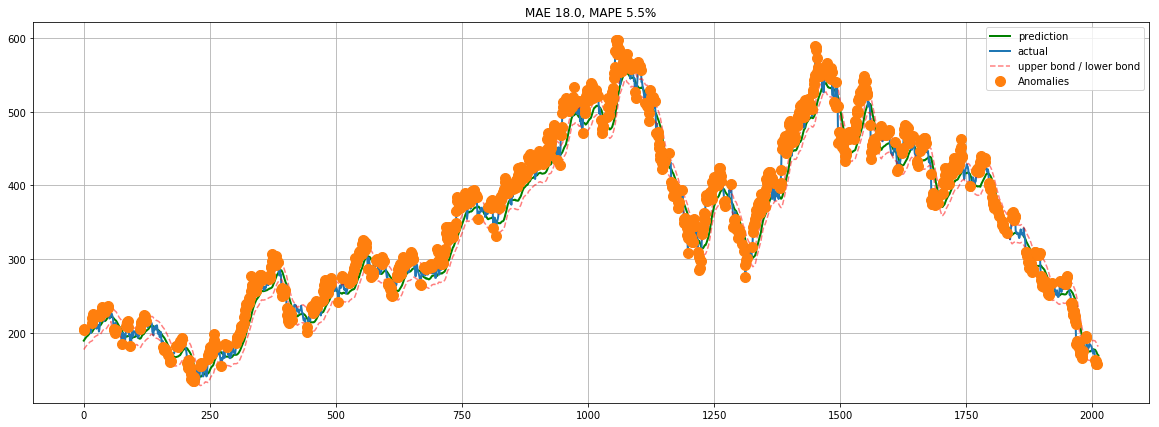

In [53]:
plotModelResults(Lasso, pca_features_train, pca_features_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)

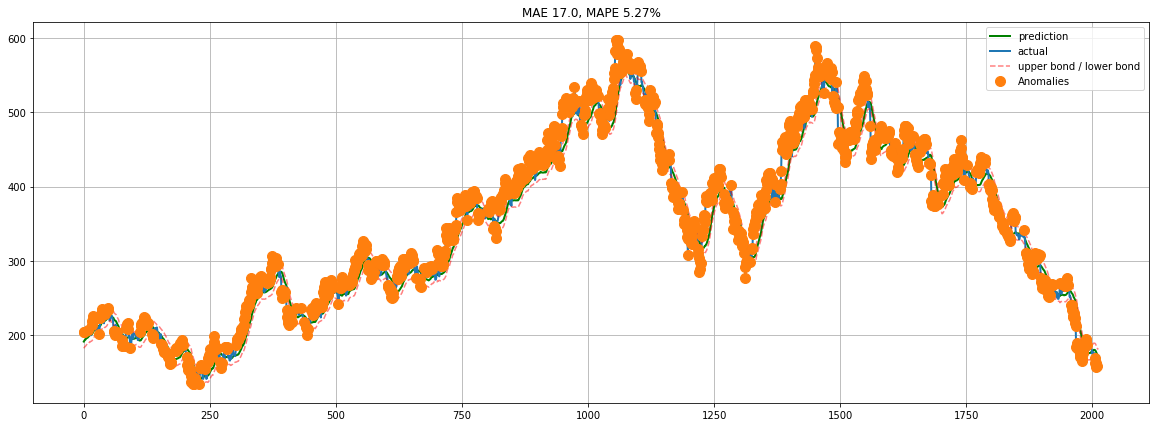

In [54]:
plotModelResults(ridge, pca_features_train, pca_features_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)

### FB Prophet

Now lets use FB-Prophet to predict the pattern

In [55]:
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

In [56]:
df_new = df['Close']

In [57]:
df_new

Date
1991-01-02     21.857901
1991-01-03     21.857901
1991-01-07     21.109301
1991-01-09     20.510500
1991-01-11     20.959600
1991-01-14     20.360800
1991-01-23     20.061300
1991-01-24     19.761900
1991-01-25     19.163099
1991-01-31     19.462500
1991-02-01     19.761900
1991-02-04     20.061300
1991-02-05     20.061300
1991-02-06     20.061300
1991-02-07     19.462500
1991-02-08     18.863600
1991-02-11     18.264799
1991-02-13     17.216801
1991-02-14     17.516199
1991-02-15     17.666000
1991-02-19     20.360800
1991-02-20     19.911600
1991-02-21     19.761900
1991-02-22     20.660200
1991-02-26     22.306999
1991-02-27     23.055599
1991-02-28     22.456699
1991-03-04     22.456699
1991-03-05     22.756100
1991-03-07     21.857901
                 ...    
2018-10-31    179.100006
2018-11-01    179.449997
2018-11-02    190.300003
2018-11-05    189.800003
2018-11-06    193.250000
2018-11-09    195.250000
2018-11-12    186.050003
2018-11-13    179.500000
2018-11-14    176.80

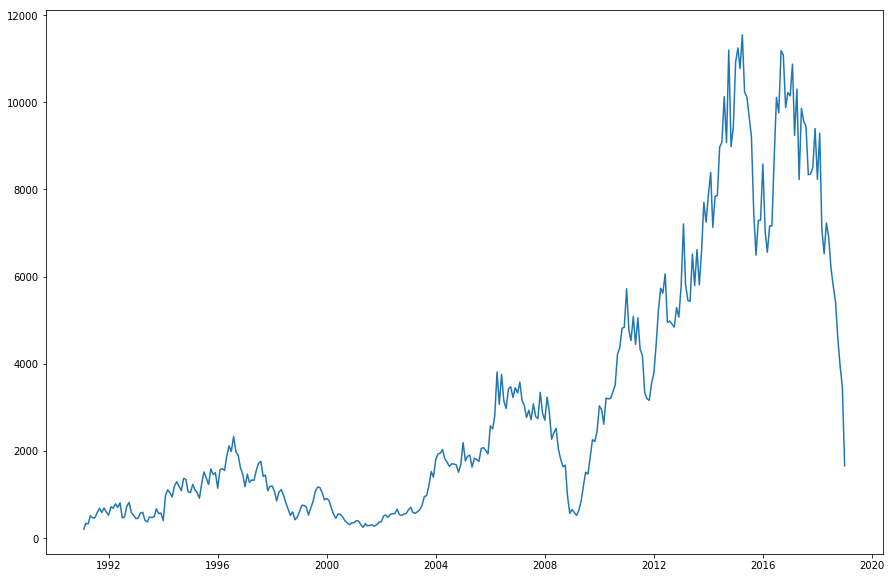

In [58]:
# Lets see the monthly pattern over the years
monthly_df = df_new.resample('M').apply(sum)
plt.figure(figsize=(15,10))
plt.plot(monthly_df)

Creating Dataset for FB-Prophet

In [59]:
df_n = df_new.reset_index()
df_n.columns = ['ds', 'y']
df_n = df_n.reset_index(drop=True)

In [60]:
prediction_size = 30 # prediction for one-month
train_df = df_n[:-prediction_size]
train_df.tail(n=3)

,ds,y
6701,2018-10-26,168.500000
6702,2018-10-29,175.350006
6703,2018-10-30,177.250000


Fitting the model and Creating Future Dataframes including the history

In [61]:
m = Prophet()
m.fit(train_df);

In [62]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
6731,2018-11-27
6732,2018-11-28
6733,2018-11-29


In [63]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
6731,2018-11-27,409.925323,353.383679,469.693266,409.925323,409.925323,3.251557,3.251557,3.251557,-0.050060,-0.050060,-0.050060,3.301617,3.301617,3.301617,0.0,0.0,0.0,413.176880
6732,2018-11-28,409.932775,358.424127,471.658875,409.932775,409.932775,4.108164,4.108164,4.108164,0.929683,0.929683,0.929683,3.178482,3.178482,3.178482,0.0,0.0,0.0,414.040939
6733,2018-11-29,409.940227,354.255766,468.964394,409.940227,409.940227,3.628523,3.628523,3.628523,0.567956,0.567956,0.567956,3.060567,3.060567,3.060567,0.0,0.0,0.0,413.568750


Creating Plots to see the patterns predicted by FB-Prophet

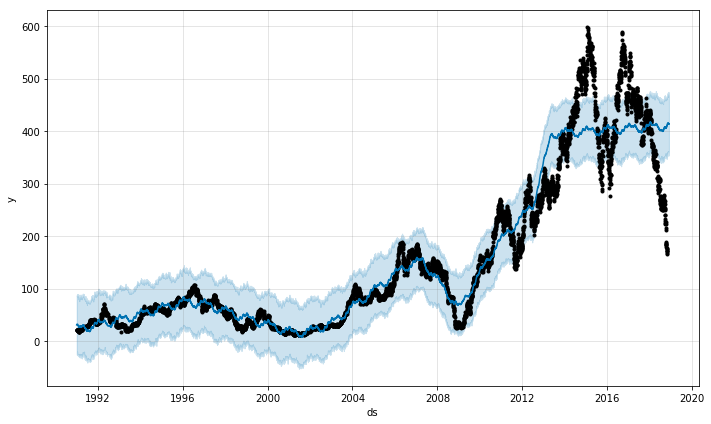

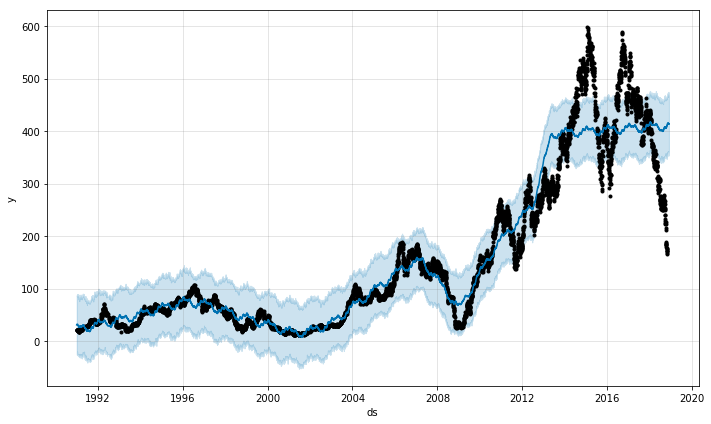

In [64]:
m.plot(forecast)

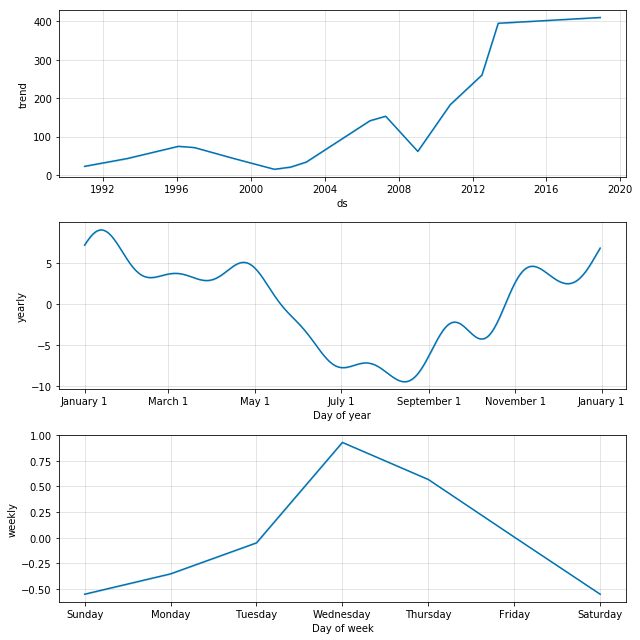

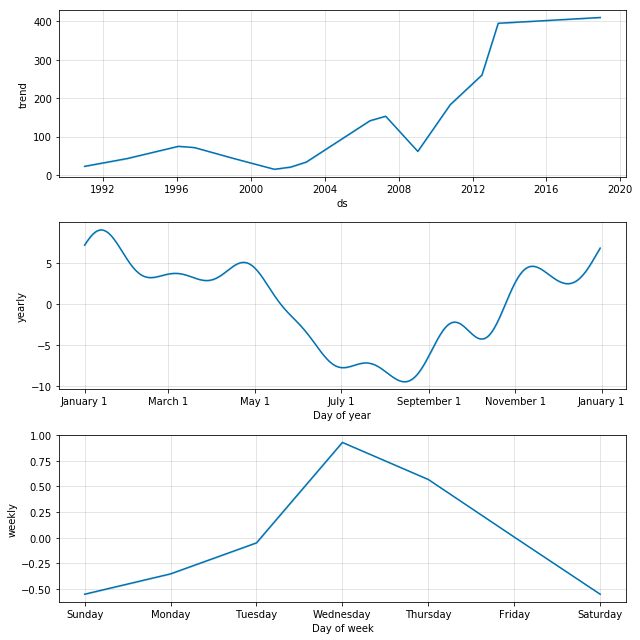

In [65]:
m.plot_components(forecast)

Above plots are self explanatory but few are important observations:

1. On Wednesdays price of this stock on an average goes up
2. August / September, prices are on an average goes down
3. After financial crisis of 2008, stock has picked up well and reached to its peak in around 2013

Lets combine Historic and Forecast data together

In [66]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [67]:
cmp_df = make_comparison_dataframe(df_n, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-11-27,413.176880,353.383679,469.693266,180.050003
2018-11-28,414.040939,358.424127,471.658875,174.449997
2018-11-29,413.568750,354.255766,468.964394,177.250000


In [68]:
prediction_size=10 # 10 days prediction
cmp_df_pred = cmp_df[-prediction_size:]
cmp_df_pred['MAE'] = cmp_df_pred['y'] - cmp_df_pred['yhat']
cmp_df_pred['MAPE'] = 100* cmp_df_pred['MAE'] / cmp_df_pred['y']

print('average MAE:', np.mean(np.abs(cmp_df_pred['MAE'])))
print('average MAPE:', np.mean(np.abs(cmp_df_pred['MAPE'])))

average MAE: 233.29776613626333
average MAPE: 129.2813554822739


FB-Prophet has not done well so far in comparison with Lasso and Ridge.

Lets normalize the data using Box-Cox transformation and see if these results have improved

In [69]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [70]:
train_df2 = train_df.copy().set_index('ds')

In [71]:
from scipy import stats
import statsmodels.api as sm
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)
train_df2.head(3)

,ds,y
0,1991-01-02,2.975885
1,1991-01-03,2.975885
2,1991-01-07,2.943449


In [72]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

In [73]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

Plotting the new components 

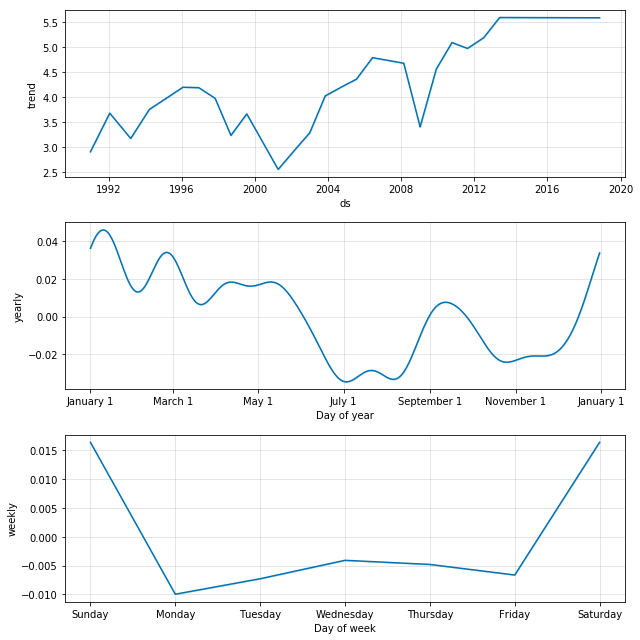

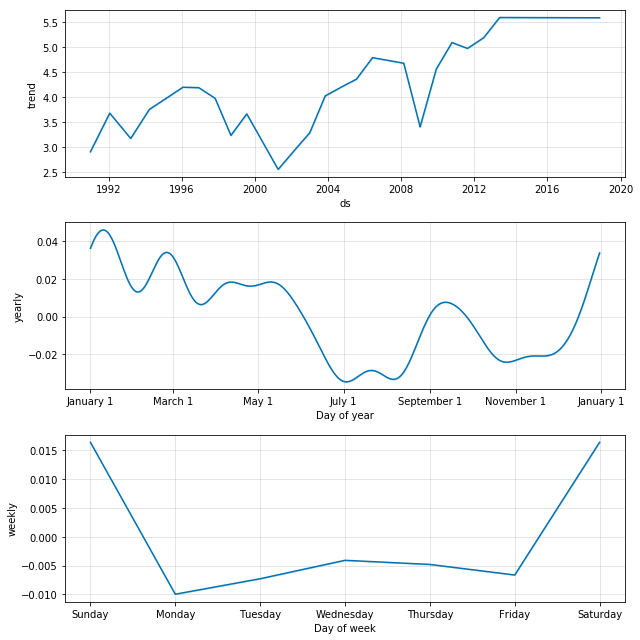

In [74]:
m2.plot_components(forecast2)

Lets create a module for forecast errors

In [75]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [76]:
cmp_df2 = make_comparison_dataframe(df_n, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 103.72984039793107
MAE 194.4139183124837


Box Cox has improved the results but still not up to the levels of Lasso and Ridge

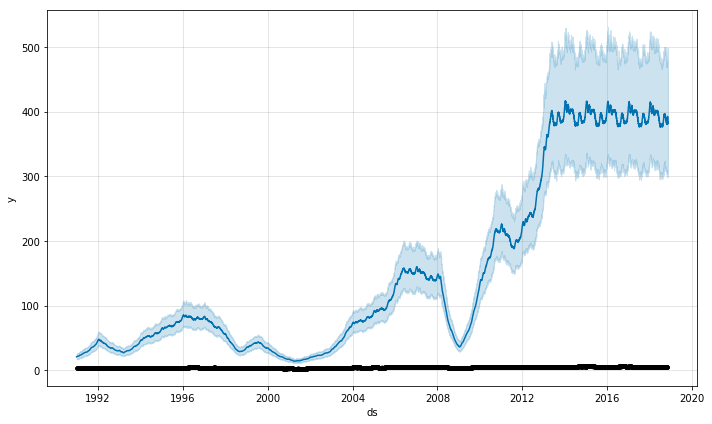

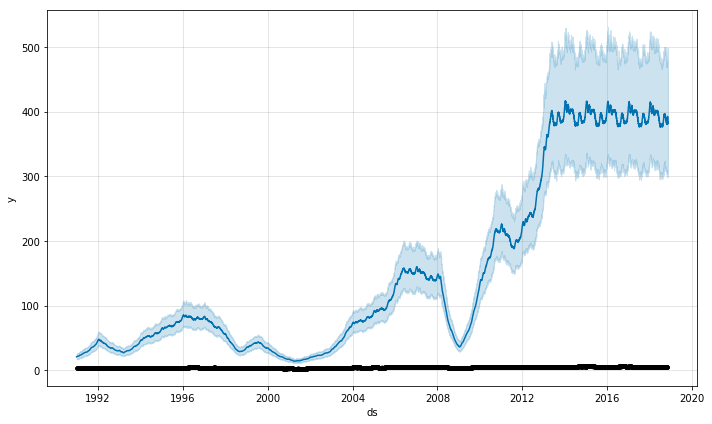

In [77]:
m2.plot(forecast2)

In [78]:
cmp_df2.tail(20)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-10-16,382.965972,303.950254,468.747673,185.850006
2018-10-17,384.038109,303.005512,484.448873,179.949997
2018-10-19,382.341780,305.403430,482.312914,174.699997
2018-10-22,380.309253,303.507277,477.081451,170.750000
2018-10-23,381.372162,307.214227,477.425928,170.649994
2018-10-24,382.700063,305.866638,481.867799,170.649994
2018-10-25,382.339647,304.439799,483.605873,165.350006
2018-10-26,381.521321,299.401269,477.680759,168.500000
2018-10-29,380.182203,305.398307,486.164947,175.350006


FB Prophet has not fared well in comparison with Lasso and Ridge (see predicted results are very far from actual values).

Now lets run 2 very powerful algorithms and see if they can beat Lasso and Ridge

In [79]:
import sys
#sys.path.append('/Users/dmitrys/xgboost/python-package/')
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

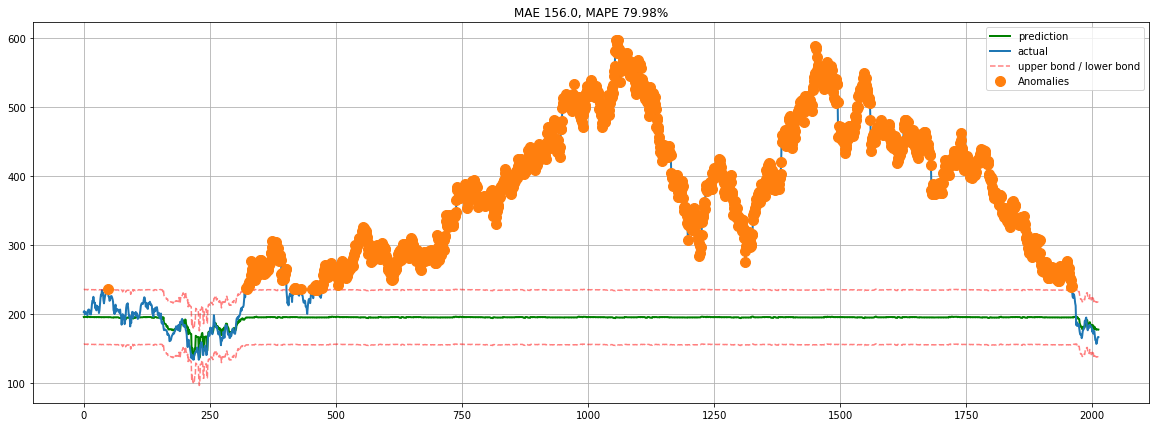

In [80]:
plotModelResults(xgb, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)

In [81]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(X_train_scaled, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

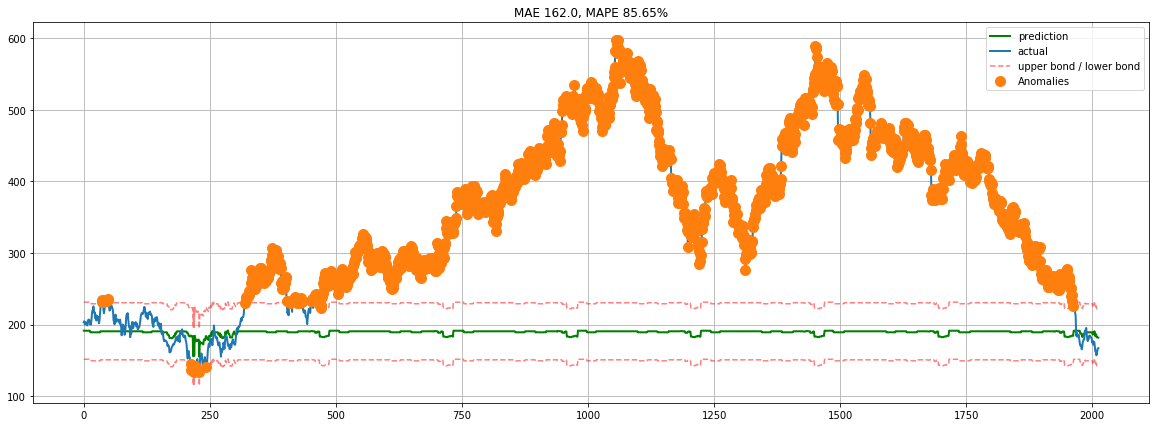

In [82]:
plotModelResults(lgb, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)

Not at all!!

Tree based algorithms are known to fail miserably on time series predictions which is evident from the above results.

Now we will do some stacking and see if results on Lasso and Ridge can be improved further.

Here we will use three classifiers:

1. Elastic Net (base)
2. Ridge (base)
3. Lasso (Meta)

In [83]:
from mlxtend.classifier import StackingClassifier
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import ElasticNet

clf1 = ElasticNet(max_iter=10000)
clf2 = ridge


sclf = StackingRegressor(regressors=[clf1, clf2], 
                          meta_regressor=lasso)

sclf.fit(X_train_scaled, y_train)


StackingRegressor(meta_regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol=0.0001, warm_start=False),
         refit=True,
         regressors=[ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, random_state=17, solver='auto', tol=0.001)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

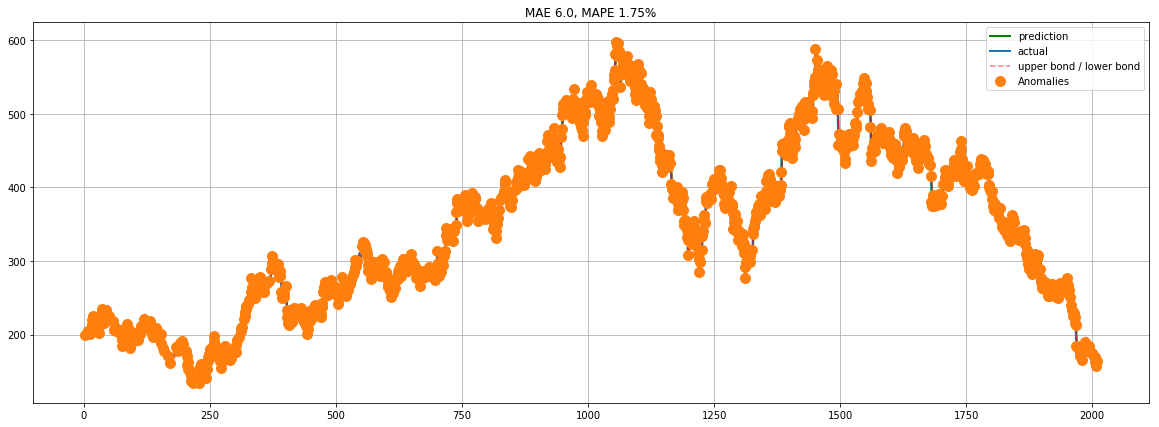

In [84]:
plotModelResults(sclf, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)

In [85]:
y_pred = sclf.predict(X_test_scaled)

columns = ['Close_actual', 'Close_pred']
df_pred_sclf = pd.DataFrame(columns = columns)

df_pred_sclf.Close_actual = y_test
df_pred_sclf.Close_pred = y_pred


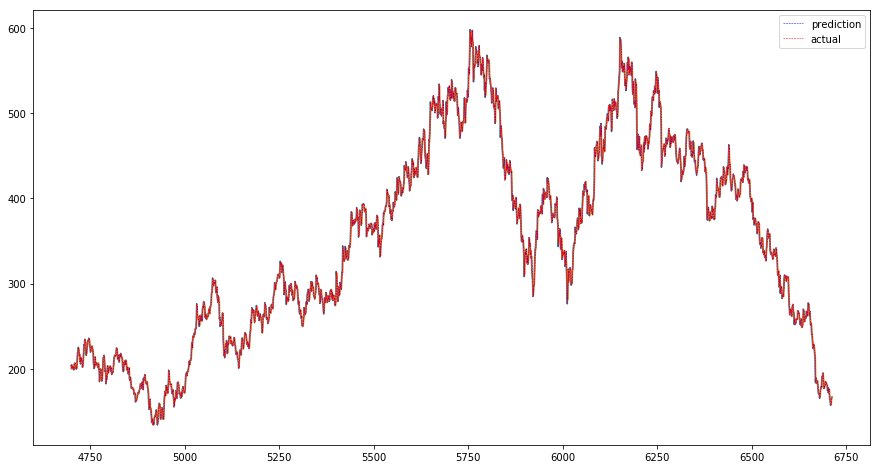

In [86]:
plt.figure(figsize=(15,8))
plt.plot(df_pred_sclf)
plt.plot(df_pred_sclf.Close_pred, "b--", label="prediction", linewidth=0.5)
plt.plot(df_pred_sclf.Close_actual, "r--", label="actual", linewidth=0.5)
plt.legend(loc="best")

In [87]:
df_pred_sclf['diff'] = df_pred_sclf.Close_actual - df_pred_sclf.Close_pred
df_pred_sclf['perc_diff'] = ((df_pred_sclf['diff']) / (df_pred_sclf['Close_pred']))*100
df_pred_sclf.head(20)

,Close_actual,Close_pred,diff,perc_diff
4700,203.47,200.666031,2.80356,1.39713
4701,204.664,203.372244,1.29138,0.634981
4702,199.958,204.824563,-4.8663,-2.37584
4703,202.19,200.148055,2.04186,1.02017
4704,203.089,201.885054,1.20429,0.596521
4705,200.235,203.273951,-3.03857,-1.49481
4706,201.87,200.223563,1.6464,0.822282
4707,198.714,202.237715,-3.52417,-1.74259
4708,205.079,199.179900,5.89894,2.96162
4709,206.652,204.426063,2.22616,1.08898


## Conclusion

Results have slightly improved. It turns out that regularized Lasso and Ridge regressions gave the best results. MAPE is around 1.76% and MAE is around INR 6. This is remarkable and it can be further improved through the ways of Hyperparameter tuning or through some advanced techniques such as LSTM.